In [6]:
# used to reload the imported modules on save
%load_ext autoreload
%autoreload 2

import utils as u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import cv2
import os

In [8]:
# constants
GRID_SIZE = (10,17)
SQUARE_SIZE = 15

# getting the images path
images_pathname = "../our_calibration_images/"
images_path = [os.path.join(images_pathname, imagename) for imagename in os.listdir(images_pathname) if imagename.endswith(".jpg")]

# Sorting the lists of strings in numerical order
images_path.sort(key=lambda x: int(x.split('-WA')[-1].split('.')[0]))


## Exercise 1

In [9]:
V = []
all_H = []

# getting the homographies for each image
for img in images_path:
    H = u.get_homography(img, GRID_SIZE, SQUARE_SIZE)
    all_H.append(H)
    
    v_12 = u.get_v_vector(H, 1, 2)
    v_11 = u.get_v_vector(H, 1, 1)
    v_22 = u.get_v_vector(H, 2, 2)
    
    V.append(v_12)
    V.append(v_11 - v_22)
    
# computing params
V = np.array(V)
K = u.get_intrinsic(V)

all_R = []
all_t = []

# computing extrinsic for each image
for H in all_H:
    R, t = u.get_extrinsic(K, H)
    all_R.append(R)
    all_t.append(t)

print("Example params: \n")
print(f"- K -\n{np.array2string(K, precision=3, suppress_small=True)}\n")
print(f"- R -\n{np.round(all_R[0], 3)}\n")
print(f"- t - \n{np.round(all_t[0], 3)}\n")

Example params: 

- K -
[[1278.595    2.867  799.394]
 [   0.    1273.183  553.586]
 [   0.       0.       1.   ]]

- R -
[[-0.995  0.053 -0.089]
 [ 0.06   0.995 -0.074]
 [ 0.085 -0.079 -0.993]]

- t - 
[166.463 -72.822 402.176]



## Exercise 2

In [ ]:
old_w, old_h = 1600, 1200
new_w, new_h = 1280, 720
sx = new_w / old_w
sy = new_h / old_h

K_scaled = K.copy()
K_scaled[0, 0] *= sx  # alpha_u
K_scaled[1, 1] *= sy  # alpha_v
K_scaled[0, 2] *= sx  # u0
K_scaled[1, 2] *= sy  # v0

viz_img_index = 0 
projected_corners_viz = []
image_to_show = None
total_sum_error = 0.0

for i, img in enumerate(images_path):
    P = u.get_projection_matrix(K_scaled, all_R[i], all_t[i])

    corners_orig = u.get_corners(img, GRID_SIZE)

    grid_size_cv2 = tuple(reversed(GRID_SIZE))
    for index, corner in enumerate(corners_orig):
        u_coord = corner[0] * sx 
        v_coord = corner[1] * sy
        
        u_index, v_index = np.unravel_index(index, grid_size_cv2)
        point_m = np.array([u_index * SQUARE_SIZE, v_index * SQUARE_SIZE, 0, 1])

        projected_u, projected_v = u.project(point_m, P)[0]
        
        error += (projected_u - u_coord)**2 + (projected_v - v_coord)**2
        total_corners_count += 1

        if i == viz_img_index:
            projected_corners_viz.append((projected_u, projected_v))


if total_corners_count > 0:
    print(f"Total error (all images): {error:.2f}")
    print(f"Mean error per corner (total): {error/total_corners_count:.4f}")


raw_img = cv2.imread(images_path[viz_img_index])
# Important: the image must be resized to match K_scaled and the points.
img_resized = cv2.resize(raw_img, (new_w, new_h))
image_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

for cp in projected_corners_viz:
    cv2.circle(image_rgb, (int(cp[0]), int(cp[1])), radius=3, color=(255, 0, 0), thickness=-1)

px.imshow(image_rgb)

NameError: name 'error' is not defined

### Exercise 3

In [ ]:
import random

random.seed(0)
NUM_IMAGES_TO_PROCESS = 25

images_indices = random.sample(range(len(images_path)), NUM_IMAGES_TO_PROCESS)

# 3D parameters of the cylinder (remain fixed for all projections)
radius_mm = 22.0
height_mm = 80.0

# Positioning consistent with the origin of the checkerboard (e.g. 4 squares, 4 squares)
center_x_mm = 5 * SQUARE_SIZE 
center_y_mm = 4 * SQUARE_SIZE
num_sides_cyl = 30 # Cylinder resolution
num_height_slices_cyl = 5

superimposed_image_list = []

for i in images_indices:
    img_path = images_path[i]
    R_i = all_R[i]
    t_i = all_t[i]
    P = u.get_projection_matrix(K, R_i, t_i)
    
    superimposed_image = u.superimpose_cylinder(
        img_path=img_path, 
        P=P,
        radius=radius_mm, 
        height=height_mm, 
        center_x=center_x_mm, 
        center_y=center_y_mm,
        num_sides=num_sides_cyl,
        num_height_slices=num_height_slices_cyl
    )
    
    superimposed_image_list.append(superimposed_image)
    
px.imshow(superimposed_image_list[0])

### Exercise 4

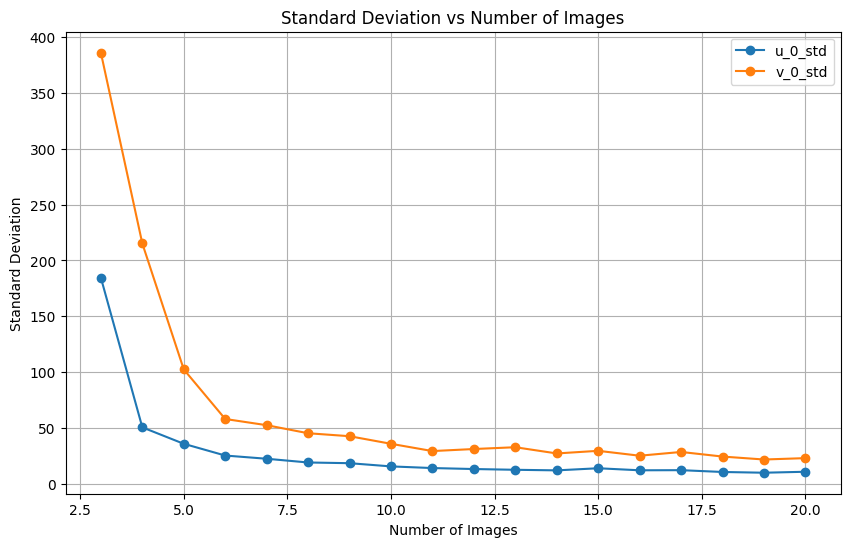

In [ ]:
random.seed(0)
max_N_images = 20
N_images = list(range(3, max_N_images + 1))
n_samples = 100

# since V is a stack of two equations per image,
# I can use them to compute K instead of recomputing V each time
index_to_select = list(range(0, len(V), 2))

u0_std = []
v0_std = []

for n_images in range(3, max_N_images + 1):
    current_sample = 1
    principal_point_coord = []
    while current_sample <= n_samples:
        selected_images = np.array(random.sample(index_to_select, n_images))
        _V = np.concatenate([V[selected_images], V[selected_images + 1]])

        # some matrices could be not positive definite -> no solution
        try:
            K = u.get_intrinsic(np.array(_V))
        except:
            continue
        
        principal_point_coord.append([K[0,2], K[1,2]])
        current_sample += 1
    
    principal_point_coord = np.stack(principal_point_coord)
    _u0_std, _v0_std = principal_point_coord.std(axis=0)
    u0_std.append(_u0_std.item())
    v0_std.append(_v0_std.item())
    
plt.figure(figsize=(10, 6))
plt.plot(N_images, u0_std, marker='o', label='u_0_std')
plt.plot(N_images, v0_std, marker='o', label='v_0_std')
plt.xlabel('Number of Images')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Number of Images')
plt.grid(True)
plt.legend()
plt.show()